# Computer Vision - Assignment 2

* Name: **Gokulraj R**
* Roll Number: **2020102042**

In [2]:
!pip install tabulate

## Imports

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

## 1. Own Calibration

### 1.1

In [4]:
# Load the image
image = cv2.imread('calib-object.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [92]:
def detect_corners(gray, pattern_size):
    # Get the image dimensions
    height, width = gray.shape

    # Define the pattern size for left and right halves
    # pattern_size = (6, 8)

    # Split the image into left and right halves
    left_half = gray[:, :width//2]
    right_half = gray[:, width//2:]

    # Find chessboard corners on the left half
    ret_left, corners_left = cv2.findChessboardCorners(left_half, pattern_size, 
                                                        flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Find chessboard corners on the right half
    ret_right, corners_right = cv2.findChessboardCorners(right_half, pattern_size, 
                                                        flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Draw corners on the left half
    if ret_left:
        left_marked = cv2.drawChessboardCorners(left_half, pattern_size, corners_left, ret_left)
    else:
        print("Chessboard corners not found on the left half")

    # Draw corners on the right half
    if ret_right:
        # corners_right[:, :, 0] += width//2  # Adjust x-coordinates for the right half
        right_marked = cv2.drawChessboardCorners(right_half, pattern_size, corners_right, ret_right)
    else:
        print("Chessboard corners not found on the right half")

    # Concatenate left and right halves
    # result_image = np.concatenate((left_half, right_half), axis=1)
    result_image = cv2.hconcat([left_marked, right_marked])
    
    return result_image

In [93]:
img_with_corners = detect_corners(gray, (6, 8))
cv2.imwrite('calib-object_corners.jpg', img_with_corners)

True

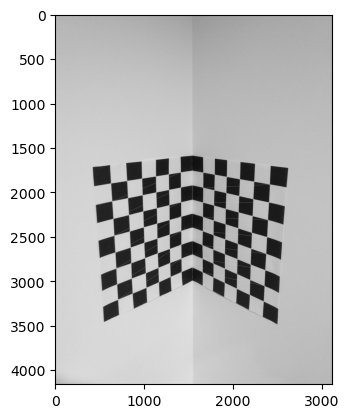

In [97]:
plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_GRAY2RGB))
plt.show()

* The corners are marked in the image, but they are too thin to be seen with the naked eye.

### 1.2

* Assume world origin at top middle of the chess board pattern.
* Consider the following world points:

In [13]:
l = 2
world_points_calib1 = np.array([
        [0, 0, 0],
        [0, l, 2*l],
        [0, 2*l, 4*l],
        [0, 3*l, 6*l],
        [2*l, l, 0],
        [4*l, 2*l, 0],
        [6*l, 3*l, 0],
        [0, 3*l, l],
        [0, 4*l, 3*l],
        [0, 5*l, 5*l],
        [l, 3*l, 0],
        [3*l, 4*l, 0],
        [5*l, 5*l, 0],
        [0, 6*l, 0],
        [0, 7*l, 2*l],
        [0, 8*l, 4*l],
        [2*l, 7*l, 0],
        [4*l, 8*l, 0],
        [0, 7*l, 6*l],
        [6*l, 7*l, 0],
    ])

* We choose the corresponding image points on the given image.
* The following function opens a window where we can select the image points cooresponding to the world points by clicking on the image.

In [5]:
def annotateImage(img_path, annotated_img_path):
    img = cv2.imread(img_path, -1)
    total_img_points = []

    def highlight_pixel(event, x, y, flags, param):
        if event == cv2.EVENT_FLAG_RBUTTON:
            # Highlight the pixel at (x, y)
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

            # Annotate the pixel at (x, y)
            cv2.putText(img, "({}, {})".format(x, y), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            total_img_points.append(np.array([x, y]))
        
    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
    cv2.setMouseCallback("Image", highlight_pixel)

    while True:
        cv2.imshow("Image", img)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("r"):
            img = cv2.imread(img_path, -1)
            total_img_points = []

        elif key == ord("q"):
            break

    cv2.destroyAllWindows()
    cv2.imwrite(annotated_img_path, img)

    return np.array(total_img_points)

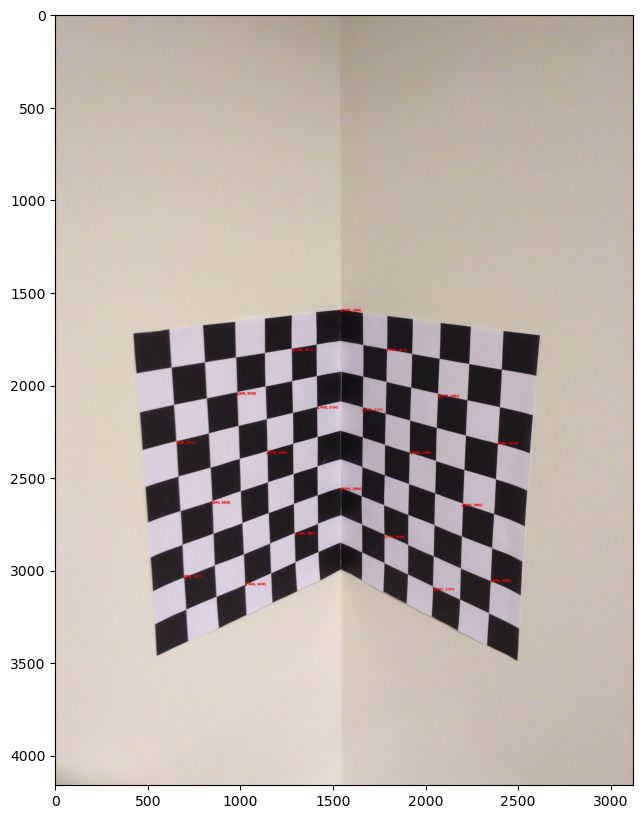

In [8]:
img_points_calib1 = annotateImage('calib-object.jpg', 'calib-object-annotated.jpg')
annotated_img1 = cv2.imread('calib-object-annotated.jpg', -1)
annotated_img1 = cv2.cvtColor(annotated_img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img1)
plt.show()

* Now that we have many image point, world point pair, we can estimate the projection matrix.
* The projection matrix can then be decomposed into intrinsic and extrinsic matrix using QR decomposition.

In [14]:
def calibrateCamera(img_points, world_points):
    # Convert to homogeneous coordinates
    img_points = np.append(img_points, [[1] for i in range(img_points.shape[0])], axis=1)
    world_points = np.append(world_points, [[1] for i in range(world_points.shape[0])], axis=1)
    
    n = img_points.shape[0]
    A = np.zeros((2*n, 12))
    for i in range(n):
        A[2*i, 0:4] = -world_points[i]
        A[2*i+1, 4:8] = -world_points[i]
        A[2*i, 8:12] = img_points[i, 0] * world_points[i]
        A[2*i+1, 8:12] = img_points[i, 1] * world_points[i]
    u, s, vh = np.linalg.svd(A)
    P = vh[-1].reshape(3, 4)

    # Estimate projection center C
    C = np.array(np.dot(-np.linalg.inv(P[:, 0:3]), P[:, 3]))

    # Perform QR decomposition of P
    Q, R = np.linalg.qr(np.linalg.inv(P[:, 0:3]))

    # Estimate Calibration matrix K
    K = np.linalg.inv(R)
    K = K / K[2, 2]

    # Estimate rotation matrix R
    R = np.transpose(Q)
    
    return P, C, K, R

In [15]:
P, C, K, R = calibrateCamera(img_points_calib1, world_points_calib1)
print('Estimated Projection Matrix:')
print(tabulate(P, tablefmt="rounded_outline"))
# print('\nEstimated Projection Center:')
# print(tabulate(C, tablefmt="plain"))
print('\nEstimated Calibration Matrix:')
print(tabulate(K, tablefmt="rounded_outline"))
print('\nEstimated Rotation Matrix:')
print(tabulate(R, tablefmt="rounded_outline"))

Estimated Projection Matrix:
╭─────────────┬──────────────┬──────────────┬──────────────╮
│ 0.0384563   │ -0.0035874   │ -0.0152052   │ -0.693163    │
│ 0.00688108  │ -0.0418611   │  0.00801994  │ -0.718288    │
│ 6.53421e-06 │ -2.27367e-06 │  7.21297e-06 │ -0.000448475 │
╰─────────────┴──────────────┴──────────────┴──────────────╯

Estimated Calibration Matrix:
╭──────────┬───────────┬─────────╮
│ -3873.02 │  -10.3932 │ 1499.25 │
│     0    │ 3838.22   │ 1982.01 │
│     0    │    0      │    1    │
╰──────────┴───────────┴─────────╯

Estimated Rotation Matrix:
╭───────────┬─────────────┬───────────╮
│ -0.739963 │  0.00722718 │  0.672609 │
│ -0.158227 │ -0.973754   │ -0.163609 │
│  0.653773 │ -0.227489   │  0.721685 │
╰───────────┴─────────────┴───────────╯


In [16]:
P

array([[ 3.84562982e-02, -3.58739658e-03, -1.52052032e-02,
        -6.93163289e-01],
       [ 6.88108037e-03, -4.18611016e-02,  8.01994239e-03,
        -7.18287880e-01],
       [ 6.53421184e-06, -2.27366669e-06,  7.21297201e-06,
        -4.48475149e-04]])

### 1.3

* The world points to compute the image of the wireframe are:

In [17]:
world_points_1 = np.array([
    [7*l, 0, 0],
    [0, 0, 0],
    [0, 0, 7*l],
    [0, 9*l, 7*l],
    [0, 9*l, 0],
    [7*l, 9*l, 0],
])
world_points_1 = np.append(world_points_1, [[1] for i in range(world_points_1.shape[0])], axis=1)
print(world_points_1)

[[14  0  0  1]
 [ 0  0  0  1]
 [ 0  0 14  1]
 [ 0 18 14  1]
 [ 0 18  0  1]
 [14 18  0  1]]


* Computing the image points for these world points using the projection matrix.

In [18]:
image_points_1 = np.array(np.dot(P, world_points_1.T).T)
image_points_1 = image_points_1 / image_points_1[:, 2].reshape(-1, 1)
image_points_1 = image_points_1[:, 0:2]
image_points_1 = np.array(image_points_1, dtype=int)
print(image_points_1)

[[ 433 1742]
 [1545 1601]
 [2607 1743]
 [2498 3500]
 [1548 3007]
 [ 551 3456]]


In [19]:
image_points_1 = image_points_1[:, :2].reshape(-1, 1, 2)
print(image_points_1)

[[[ 433 1742]]

 [[1545 1601]]

 [[2607 1743]]

 [[2498 3500]]

 [[1548 3007]]

 [[ 551 3456]]]


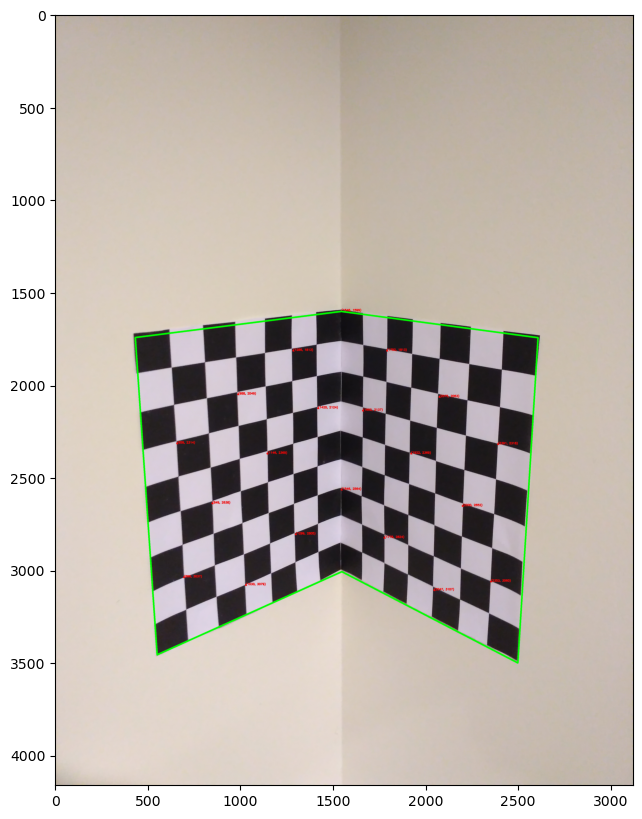

In [20]:
wireframe = cv2.polylines(annotated_img1, [image_points_1], True, (0, 255, 0), 8)
cv2.imwrite('calib-object_wireframe.jpg', wireframe)
plt.figure(figsize=(10, 10))
plt.imshow(wireframe)
plt.show()

#### Observations
* The wireframe will be fit the image more precisely if the image points are selected more accurately.

### 1.4

In [21]:
# Tilt (around x-axis)
tilt = np.arctan2(R[2, 1], R[2, 2])

# Pan (around y-axis)
pan = np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2))

# Roll (around z-axis)
roll = np.arctan2(R[1, 0], R[0, 0])

# Convert angles from radians to degrees
tilt_degrees = np.degrees(tilt)
pan_degrees = np.degrees(pan)
roll_degrees = np.degrees(roll)

print("Tilt:", tilt_degrees, "degrees")
print("Pan:", pan_degrees, "degrees")
print("Roll:", roll_degrees, "degrees")

Tilt: -17.495847964135503 degrees
Pan: -40.82666600359833 degrees
Roll: -167.93016903017246 degrees


* These three angles are the rotation angles of the camera with respect to the world coordinate system.

## 2. OpenCV Calibration

### 2.1

* We use the same world points and image points as in question 1.
* We first use coplanar points to get an initial guess for intrinsic matrix.

In [22]:
# indices = [0, 1, 2, 3, 7, 8, 9, 13, 14, 15, 18]
indices = [4, 5, 6, 10, 11, 12, 16, 17, 19]
# get world_points_calib1 from these indices
coplanar_world_points_1 = world_points_calib1[indices].astype(np.float32)
print(coplanar_world_points_1)

[[ 4.  2.  0.]
 [ 8.  4.  0.]
 [12.  6.  0.]
 [ 2.  6.  0.]
 [ 6.  8.  0.]
 [10. 10.  0.]
 [ 4. 14.  0.]
 [ 8. 16.  0.]
 [12. 14.  0.]]


* The corresponding image points are:

In [23]:
coplanar_image_points_1 = img_points_calib1[indices].astype(np.float32)
print(coplanar_image_points_1)

[[1286. 1813.]
 [ 988. 2049.]
 [ 659. 2314.]
 [1420. 2124.]
 [1146. 2369.]
 [ 849. 2638.]
 [1299. 2805.]
 [1030. 3079.]
 [ 696. 3037.]]


* Initial Estimate of Intrinsic Matrix

In [42]:
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera([coplanar_world_points_1], [coplanar_image_points_1], image.shape[:2], None, None)

* We then use the initial estimate of intrinsic matrix to get a better estimate of the intrinsic matrix using the non-coplanar points.

In [43]:
world_points_calib1 = world_points_calib1.astype(np.float32)
img_points_calib1 = img_points_calib1.astype(np.float32)

In [44]:
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera([world_points_calib1], [img_points_calib1], image.shape[:2], camera_matrix, dist_coeffs, flags=cv2.CALIB_USE_INTRINSIC_GUESS)

* Obtaining rotation matrix and projection matrix using the intrinsic matrix.

In [45]:
# Rotation Matrix
R1_opencv, _ = cv2.Rodrigues(rvecs[0])
print(R1_opencv)

C_opencv = tvecs[0]

P1_opencv = np.dot(camera_matrix, np.c_[R1_opencv, C_opencv])
print(P1_opencv)

[[-0.73720444  0.00483095  0.67565248]
 [ 0.09883208  0.98999     0.1007572 ]
 [-0.66840245  0.14105479 -0.73030248]]
[[-3.79059292e+03  2.31734843e+02  1.44125675e+03  6.77350096e+04]
 [-7.10296720e+02  4.02732144e+03 -8.03800331e+02  7.00681209e+04]
 [-6.68402450e-01  1.41054794e-01 -7.30302478e-01  4.38445097e+01]]


* World points to compute the image of the wireframe are:

In [48]:
print(world_points_1)

[[14  0  0  1]
 [ 0  0  0  1]
 [ 0  0 14  1]
 [ 0 18 14  1]
 [ 0 18  0  1]
 [14 18  0  1]]


* Corresponding image points computed using the estimated projection matrix P obtained using opencv functions.

In [50]:
image_points_1_opencv = np.array(np.dot(P1_opencv, world_points_1.T).T)
image_points_1_opencv = image_points_1_opencv / image_points_1_opencv[:, 2].reshape(-1, 1)
image_points_1_opencv = image_points_1_opencv[:, 0:2]
image_points_1_opencv = np.array(image_points_1_opencv, dtype=int)
image_points_1_opencv = image_points_1_opencv[:, :2].reshape(-1, 1, 2)
print(image_points_1_opencv)

[[[ 425 1743]]

 [[1544 1598]]

 [[2614 1749]]

 [[2546 3631]]

 [[1550 3073]]

 [[ 508 3581]]]


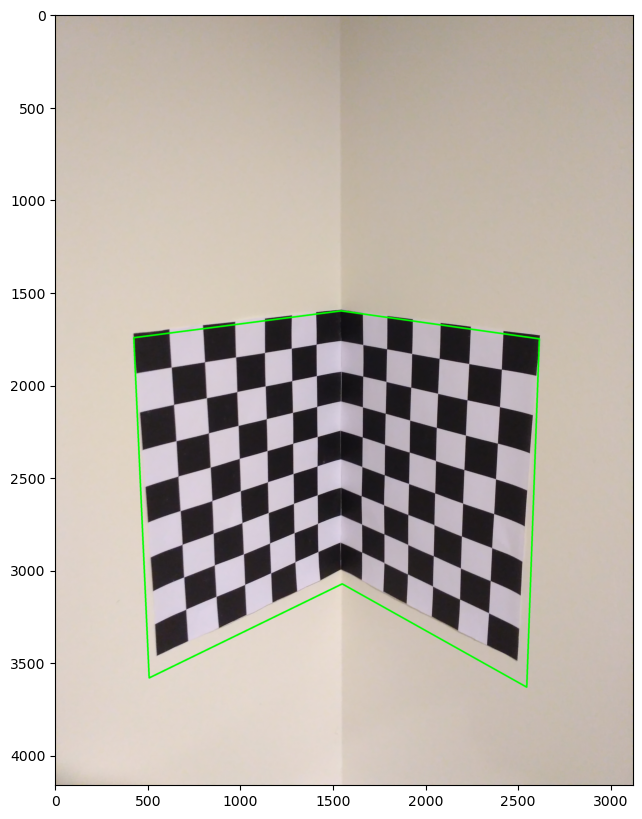

In [54]:
wireframe1_opencv = cv2.polylines(image, [image_points_1_opencv], True, (0, 255, 0), 8)
cv2.imwrite('calib-object_wireframe_opencv.jpg', wireframe1_opencv)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(wireframe1_opencv, cv2.COLOR_BGR2RGB))
plt.show()

* This wireframe will also fit the image more precisely if the image points are selected more accurately.

### 2.2

In [74]:
image2 = cv2.imread('assign1.jpg')

* Assuming the world origin at the top left of the chess board pattern, we can use the following world points:

In [75]:
l = 2
world_points_calib2 = np.array([
    [0, 0, 0],
    [2*l, 0, 0],
    [4*l, 0, 0],
    [6*l, 0, 0],
    [0, 2*l, 0],
    [0, 4*l, 0],
    [0, 6*l, 0],
    [l, l, 0],
    [3*l, l, 0],
    [5*l, l, 0],
    [l, 3*l, 0],
    [l, 5*l, 0],
    [2*l, 2*l, 0],
    [4*l, 2*l, 0],
    [6*l, 2*l, 0],
    [2*l, 4*l, 0],
    [2*l, 6*l, 0],
    [3*l, 3*l, 0],
    [5*l, 3*l, 0],
    [3*l, 5*l, 0]
])

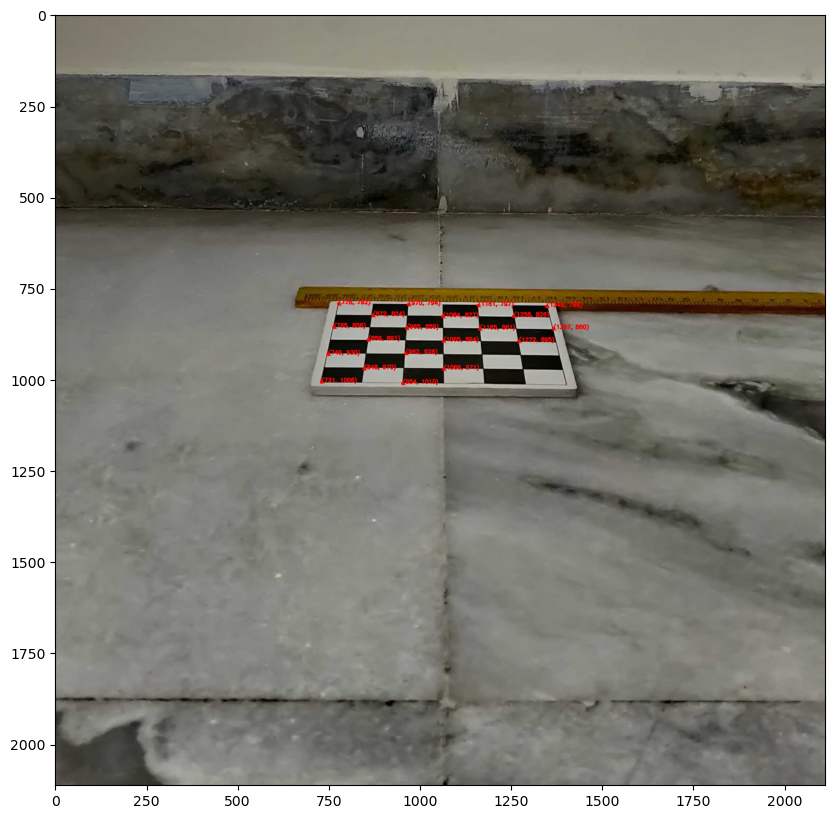

In [76]:
img_points_calib2 = annotateImage('assign1.jpg', 'assign1-annotated.jpg')
annotated_img2 = cv2.imread('assign1-annotated.jpg', -1)
annotated_img2 = cv2.cvtColor(annotated_img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img2)
plt.show()

In [77]:
world_points_calib2 = np.array(world_points_calib2, dtype=np.float32)
img_points_calib2 = np.array(img_points_calib2, dtype=np.float32)

print(world_points_calib2)
print(img_points_calib2)

[[ 0.  0.  0.]
 [ 4.  0.  0.]
 [ 8.  0.  0.]
 [12.  0.  0.]
 [ 0.  4.  0.]
 [ 0.  8.  0.]
 [ 0. 12.  0.]
 [ 2.  2.  0.]
 [ 6.  2.  0.]
 [10.  2.  0.]
 [ 2.  6.  0.]
 [ 2. 10.  0.]
 [ 4.  4.  0.]
 [ 8.  4.  0.]
 [12.  4.  0.]
 [ 4.  8.  0.]
 [ 4. 12.  0.]
 [ 6.  6.  0.]
 [10.  6.  0.]
 [ 6. 10.  0.]]
[[ 778.  792.]
 [ 970.  794.]
 [1161.  797.]
 [1349.  799.]
 [ 765.  856.]
 [ 749.  930.]
 [ 731. 1006.]
 [ 872.  824.]
 [1064.  827.]
 [1258.  826.]
 [ 859.  891.]
 [ 848.  970.]
 [ 965.  859.]
 [1165.  861.]
 [1367.  860.]
 [ 962.  928.]
 [ 954. 1010.]
 [1065.  894.]
 [1272.  895.]
 [1066.  971.]]


In [78]:
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera([world_points_calib2], [img_points_calib2], image2.shape[1::-1], None, None)

print("Camera Matrix:")
print(camera_matrix)
print("\nDistortion Coefficients:")
print(dist_coeffs)
print("\nRotation Vectors:")
print(rvecs)
print("\nTranslation Vectors:")
print(tvecs)

Camera Matrix:
[[3.20381441e+03 0.00000000e+00 9.98470855e+02]
 [0.00000000e+00 2.65088187e+03 1.06056511e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
[[-3.37497970e+00  3.70650518e+02 -1.54543362e-02 -3.44340565e-03
  -1.06893839e+04]]

Rotation Vectors:
(array([[-1.07737936],
       [ 0.00371716],
       [ 0.01593439]]),)

Translation Vectors:
(array([[-4.60476705],
       [-6.8156766 ],
       [67.32751127]]),)


In [79]:
# Rotation Matrix
R2, _ = cv2.Rodrigues(rvecs[0])
print(R2)

C = tvecs[0]

P2 = np.dot(camera_matrix, np.c_[R2, C])
print(P2)

[[ 0.9998786  -0.01484118 -0.00474619]
 [ 0.01120917  0.47353488  0.88070374]
 [-0.0108232  -0.88065002  0.47364375]]
[[ 3.19261882e+03 -9.26851764e+02  4.57713564e+02  5.24717387e+04]
 [ 1.82354694e+01  3.21298347e+02  2.83697161e+03  5.33376555e+04]
 [-1.08231955e-02 -8.80650020e-01  4.73643749e-01  6.73275113e+01]]


* World points to draw the wireframe:

In [80]:
world_points_2 = np.array([
    [0, 0, 0],
    [6*l, 0, 0],
    [6*l, 6*l, 0],
    [0, 6*l, 0],
], dtype=np.float32)
world_points_2 = np.append(world_points_2, [[1] for i in range(world_points_2.shape[0])], axis=1)
print(world_points_2)

[[ 0.  0.  0.  1.]
 [12.  0.  0.  1.]
 [12. 12.  0.  1.]
 [ 0. 12.  0.  1.]]


In [81]:
image_points_2 = np.array(np.dot(P2, world_points_2.T).T)
image_points_2 = image_points_2 / image_points_2[:, 2].reshape(-1, 1)
image_points_2 = image_points_2[:, 0:2]
image_points_2 = np.array(image_points_2, dtype=int)
print(image_points_2)

[[ 779  792]
 [1350  796]
 [1406 1013]
 [ 728 1007]]


In [82]:
image_points_2 = image_points_2[:, :2].reshape(-1, 1, 2)
print(image_points_2)

[[[ 779  792]]

 [[1350  796]]

 [[1406 1013]]

 [[ 728 1007]]]


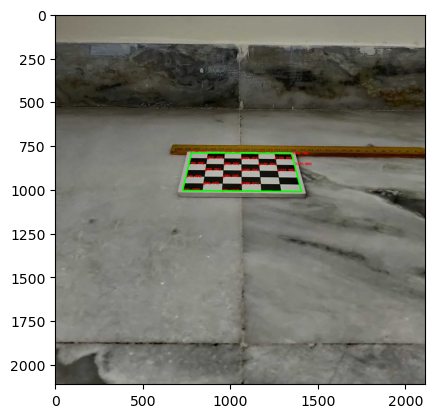

In [83]:
wireframe2 = cv2.polylines(annotated_img2, [image_points_2], True, (0, 255, 0), 8)
cv2.imwrite('assign1_wireframe.jpg', wireframe2)
# plt.imshow(cv2.cvtColor(wireframe2, cv2.COLOR_BGR2RGB))
plt.imshow(wireframe2)
plt.show()

* There were no significant distortions in the wireframe overlay.
* The computed projection matrix does not contain depth information and can only represent planar transformations.
* The projection matrix may not represent the underlying 3D geometry of the scene.

### 2.3

In [101]:
world_origin = np.array([[0, 0, 0, 1]]).astype(np.float32)
world_origin


array([[0., 0., 0., 1.]], dtype=float32)

In [102]:
image_point_origin = np.array(np.dot(P2, world_origin.T).T)
image_point_origin = image_point_origin / image_point_origin[:, 2].reshape(-1, 1)
image_point_origin = image_point_origin[:, 0:2]
image_point_origin = np.array(image_point_origin, dtype=int)
image_point_origin = image_point_origin[:, :2].reshape(-1, 1, 2)
print(image_point_origin)

[[[779 792]]]


* The image pixel for the world origin is: (779, 792).
* Expected is (778, 792), i.e., the first image point in the image points list.

## 3. Moving the Chessboard

### 3.1

* We shift all the world points by 10cm to the right.

In [84]:
world_points_3 = np.array([
    [10, 0, 0],
    [10+6*l, 0, 0],
    [10+6*l, 6*l, 0],
    [10, 6*l, 0],
], dtype=np.float32)
world_points_3 = np.append(world_points_3, [[1] for i in range(world_points_3.shape[0])], axis=1)
print(world_points_3)

[[10.  0.  0.  1.]
 [22.  0.  0.  1.]
 [22. 12.  0.  1.]
 [10. 12.  0.  1.]]


In [85]:
image_points_3 = np.array(np.dot(P2, world_points_3.T).T)
image_points_3 = image_points_3 / image_points_3[:, 2].reshape(-1, 1)
image_points_3 = image_points_3[:, 0:2]
image_points_3 = np.array(image_points_3, dtype=int)
image_points_3 = image_points_3[:, :2].reshape(-1, 1, 2)
print(image_points_3)

[[[1255  796]]

 [[1829  801]]

 [[1974 1018]]

 [[1293 1012]]]


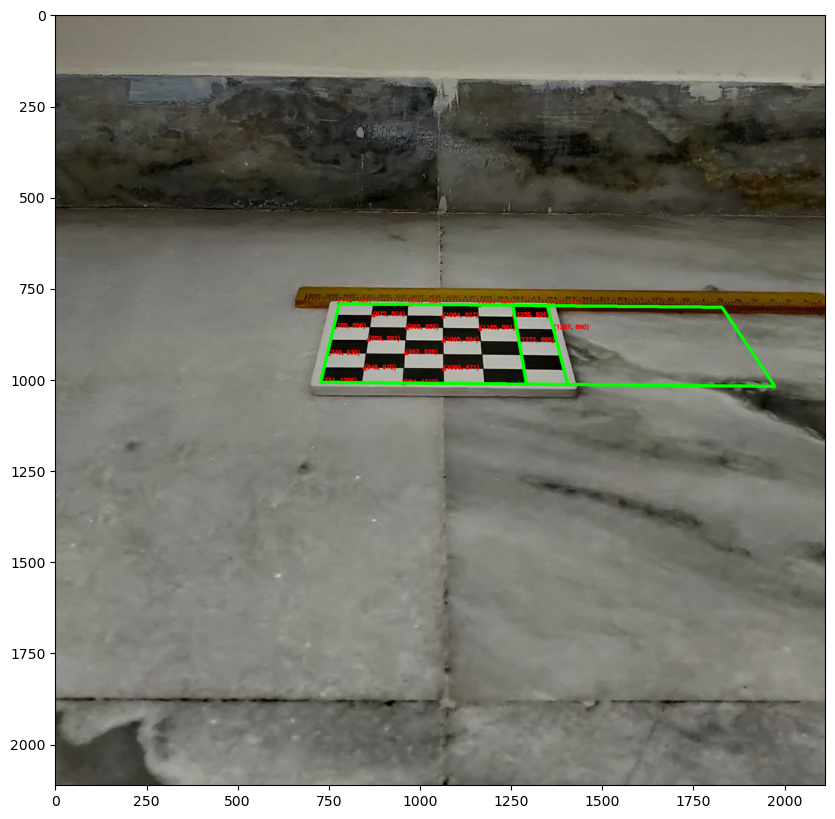

In [86]:
wireframe3 = cv2.polylines(annotated_img2, [image_points_3], True, (0, 255, 0), 8)
cv2.imwrite('assign1_wireframe_10cm.jpg', wireframe3)
plt.figure(figsize=(10,10))
plt.imshow(wireframe3)
plt.show()

* The wireframe looks consistent with the expected result. It is moved 10cm to the right.

### 3.2

* We take a grid of world points (the denser the better) and compute its original image point and the image point after shifting the world points, and copy the pixel values from the original image point to the new image point.

In [87]:
x, y = np.meshgrid(np.linspace(0, 6*l, 1000), np.linspace(0, 6*l, 1000))
grid_world_points = np.dstack([x, y]).reshape(-1, 2)
grid_world_points = np.float32(np.array([(np.array([x,y,0,1])) for x,y in grid_world_points]))
print(grid_world_points)

[[ 0.          0.          0.          1.        ]
 [ 0.01201201  0.          0.          1.        ]
 [ 0.02402402  0.          0.          1.        ]
 ...
 [11.975976   12.          0.          1.        ]
 [11.9879875  12.          0.          1.        ]
 [12.         12.          0.          1.        ]]


In [88]:
original_image_points = np.dot(P2, grid_world_points.T).T
original_image_points = np.int32( original_image_points[:, :2] / original_image_points[:, None, 2])
print(original_image_points)

[[ 779  792]
 [ 779  792]
 [ 780  792]
 ...
 [1405 1013]
 [1406 1013]
 [1406 1013]]


In [89]:
new_image_points = np.dot(P2, (grid_world_points + np.array([10, 0, 0, 0])).T).T
new_image_points = np.int32(new_image_points[:, :2] / new_image_points[:, None, 2])
print(new_image_points)

[[1255  796]
 [1256  796]
 [1256  796]
 ...
 [1972 1018]
 [1973 1018]
 [1974 1018]]


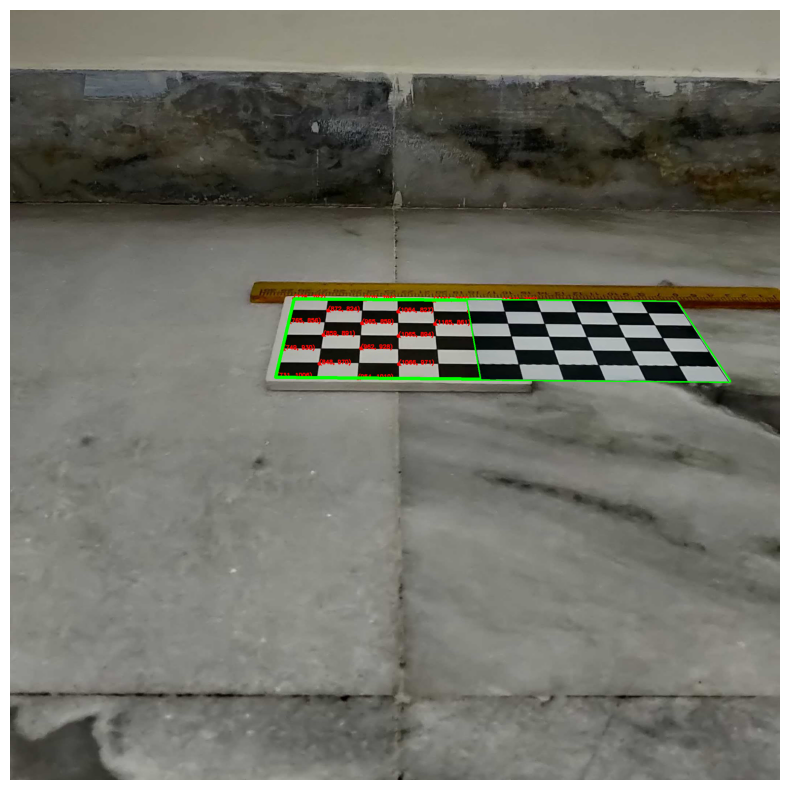

In [90]:
wireframe4 = np.copy(wireframe3)
assign1_modified =  np.copy(image2)
wireframe4[new_image_points[:, 1], new_image_points[:, 0], :] = assign1_modified[original_image_points[:, 1], original_image_points[:, 0], :]
cv2.imwrite("assign1_moved_chessboard.jpg", wireframe4)
plt.figure(figsize=(10,10))
plt.imshow(wireframe4)
plt.axis('off')  
plt.show()

* The overlay is consistent with the expected result. The image pixels are shifted 10cm to the right.